In [2]:
import torch
from torchvision import datasets, transforms

from projections import LayerModifier
from notebook_train import run_train_test_loop, test
from cifar_model import mCNN_k
from torchinfo import summary


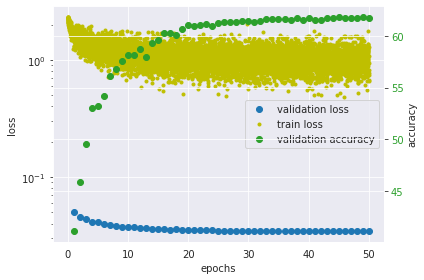

best acc: 61.85


In [10]:
# for now, no augmentations

torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset1 = datasets.CIFAR10('data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.CIFAR10('data', train=False,
                   transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, num_workers = 4, pin_memory = True, batch_size=32, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset2,  num_workers = 4, pin_memory = True, batch_size=32)

model = mCNN_k(c=8).to(device)

    
retrain = True
if retrain:
    run_train_test_loop(model, train_loader, test_loader, "cifar_10_width_8", epochs=50, device=device)    
else:
    state_dict = torch.load("models/cifar_10_width_8.pt",) # map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)


In [15]:
test(model, device, test_loader, torch.nn.CrossEntropyLoss())


Test set: Average loss: 0.0346, Accuracy: 6173/10000 (62%)



(0.03462904518842697, 61.73)

In [12]:
# pip install torchinfo
from torchinfo import summary


summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [1, 8, 32, 32]            224
├─ReLU: 1-2                              [1, 8, 32, 32]            --
├─Conv2d: 1-3                            [1, 16, 32, 32]           1,152
├─ReLU: 1-4                              [1, 16, 32, 32]           --
├─MaxPool2d: 1-5                         [1, 16, 16, 16]           --
├─Conv2d: 1-6                            [1, 32, 16, 16]           4,608
├─ReLU: 1-7                              [1, 32, 16, 16]           --
├─MaxPool2d: 1-8                         [1, 32, 8, 8]             --
├─Conv2d: 1-9                            [1, 64, 8, 8]             18,432
├─ReLU: 1-10                             [1, 64, 8, 8]             --
├─MaxPool2d: 1-11                        [1, 64, 4, 4]             --
├─MaxPool2d: 1-12                        [1, 64, 1, 1]             --
├─Fl

## CIFAR-10 experiments *with* random initialization for layers > $i$

In [16]:
c = 8
net1 = mCNN_k(c=c).to(device)

net1[0] = LayerModifier(
    torch.nn.Conv2d(3, c, kernel_size=3, stride=1, padding=1, bias=True), dims=c
).to(device)
for p in net1[0].parameters():
    p.requires_grad = False

new_state_dict = net1.state_dict()
state_dict = torch.load("models/cifar_10_width_8.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("0", "0.original_op"): v for k, v in state_dict.items()}
new_state_dict.update(state_dict)
net1.load_state_dict(new_state_dict)
test(net1, device, test_loader, torch.nn.CrossEntropyLoss())
summary(net1)


Test set: Average loss: 0.0905, Accuracy: 1745/10000 (17%)



Layer (type:depth-idx)                   Param #
Sequential                               --
├─LayerModifier: 1-1                     --
│    └─Conv2d: 2-1                       (224)
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            1,152
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            4,608
├─ReLU: 1-7                              --
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            18,432
├─ReLU: 1-10                             --
├─MaxPool2d: 1-11                        --
├─MaxPool2d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           640
Total params: 25,056
Trainable params: 24,832
Non-trainable params: 224

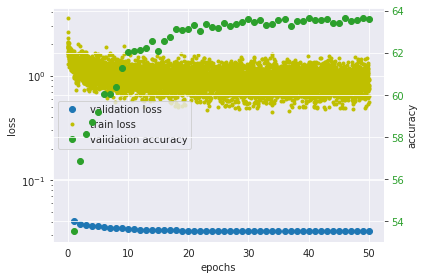

best acc: 63.64


In [17]:
run_train_test_loop(
    net1, 
    train_loader, 
    test_loader, 
    "cifar_10_width_8_freeze_layer1_reinit_conv1x1", 
    epochs=50, 
    device=device
)    

In [18]:
c = 8
net2 = mCNN_k(c=c).to(device)
net2[0] = LayerModifier(
    torch.nn.Conv2d(3, c, kernel_size=3, stride=1, padding=1, bias=True), dims=c
).to(device)
net2[2] = LayerModifier(
    torch.nn.Conv2d(c, c * 2, kernel_size=3, stride=1, padding=1, bias=False), dims=c*2
).to(device)

for p in net2[0].parameters():
    p.requires_grad = False
for p in net2[2].parameters():
    p.requires_grad = False

new_state_dict = net2.state_dict()
state_dict = torch.load("models/cifar_10_width_8_freeze_layer1_reinit_conv1x1.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("2", "2.original_op"): v for k, v in state_dict.items()}
new_state_dict.update(state_dict)
net2.load_state_dict(new_state_dict)
test(net2, device, test_loader, torch.nn.CrossEntropyLoss())
summary(net2)


Test set: Average loss: 0.1414, Accuracy: 904/10000 (9%)



Layer (type:depth-idx)                   Param #
Sequential                               --
├─LayerModifier: 1-1                     --
│    └─Conv2d: 2-1                       (224)
├─ReLU: 1-2                              --
├─LayerModifier: 1-3                     --
│    └─Conv2d: 2-2                       (1,152)
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            4,608
├─ReLU: 1-7                              --
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            18,432
├─ReLU: 1-10                             --
├─MaxPool2d: 1-11                        --
├─MaxPool2d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           640
Total params: 25,056
Trainable params: 23,680
Non-trainable params: 1,376

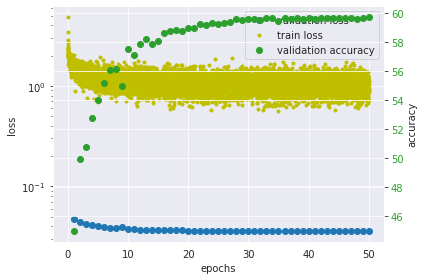

best acc: 59.7


In [19]:
run_train_test_loop(
    net2, 
    train_loader, 
    test_loader, 
    "cifar_10_width_8_freeze_layer2_reinit_conv1x1", 
    epochs=50, 
    device=device
)    

In [20]:
state_dict.keys()

dict_keys(['0.original_op.weight', '0.original_op.bias', '2.original_op.weight', '5.weight', '8.weight', '13.weight'])

In [21]:
c = 8
net3 = mCNN_k(c=c).to(device)
net3[0] = LayerModifier(
    torch.nn.Conv2d(3, c, kernel_size=3, stride=1, padding=1, bias=True), dims=c
).to(device)
net3[2] = LayerModifier(
    torch.nn.Conv2d(c, c * 2, kernel_size=3, stride=1, padding=1, bias=False), dims=c*2
).to(device)
net3[5] = LayerModifier(
    torch.nn.Conv2d(c * 2, c * 4, kernel_size=3, stride=1, padding=1, bias=False), dims=c*4
).to(device)

for p in net3[0].parameters():
    p.requires_grad = False
for p in net3[2].parameters():
    p.requires_grad = False
for p in net3[5].parameters():
    p.requires_grad = False


new_state_dict = net3.state_dict()
state_dict = torch.load("models/cifar_10_width_8_freeze_layer2_reinit_conv1x1.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("5", "5.original_op"): v for k, v in state_dict.items()}
new_state_dict.update(state_dict)
net3.load_state_dict(new_state_dict)
test(net3, device, test_loader, torch.nn.CrossEntropyLoss())
summary(net3)


Test set: Average loss: 0.1378, Accuracy: 1059/10000 (11%)



Layer (type:depth-idx)                   Param #
Sequential                               --
├─LayerModifier: 1-1                     --
│    └─Conv2d: 2-1                       (224)
├─ReLU: 1-2                              --
├─LayerModifier: 1-3                     --
│    └─Conv2d: 2-2                       (1,152)
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─LayerModifier: 1-6                     --
│    └─Conv2d: 2-3                       (4,608)
├─ReLU: 1-7                              --
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            18,432
├─ReLU: 1-10                             --
├─MaxPool2d: 1-11                        --
├─MaxPool2d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           640
Total params: 25,056
Trainable params: 19,072
Non-trainable params: 5,984

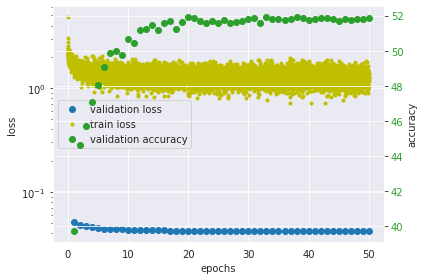

best acc: 51.92


In [22]:
run_train_test_loop(
    net3, 
    train_loader, 
    test_loader, 
    "cifar_10_width_8_freeze_layer3_reinit_conv1x1", 
    epochs=50, 
    device=device
)    

In [24]:
c = 8
net4 = mCNN_k(c=c).to(device)
net4[0] = LayerModifier(
    torch.nn.Conv2d(3, c, kernel_size=3, stride=1, padding=1, bias=True), dims=c
).to(device)
net4[2] = LayerModifier(
    torch.nn.Conv2d(c, c * 2, kernel_size=3, stride=1, padding=1, bias=False), dims=c*2
).to(device)
net4[5] = LayerModifier(
    torch.nn.Conv2d(c * 2, c * 4, kernel_size=3, stride=1, padding=1, bias=False), dims=c*4
).to(device)
net4[8] = LayerModifier(
    torch.nn.Conv2d(c * 4, c * 8, kernel_size=3, stride=1, padding=1, bias=False), dims=c*8
).to(device)

for p in net4[0].parameters():
    p.requires_grad = False
for p in net4[2].parameters():
    p.requires_grad = False
for p in net4[5].parameters():
    p.requires_grad = False
for p in net4[8].parameters():
    p.requires_grad = False


new_state_dict = net4.state_dict()
state_dict = torch.load("models/cifar_10_width_8_freeze_layer3_reinit_conv1x1.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("8", "8.original_op"): v for k, v in state_dict.items()}
new_state_dict.update(state_dict)
net4.load_state_dict(new_state_dict)
test(net4, device, test_loader, torch.nn.CrossEntropyLoss())
summary(net4)


Test set: Average loss: 1.0934, Accuracy: 1027/10000 (10%)



Layer (type:depth-idx)                   Param #
Sequential                               --
├─LayerModifier: 1-1                     --
│    └─Conv2d: 2-1                       (224)
├─ReLU: 1-2                              --
├─LayerModifier: 1-3                     --
│    └─Conv2d: 2-2                       (1,152)
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─LayerModifier: 1-6                     --
│    └─Conv2d: 2-3                       (4,608)
├─ReLU: 1-7                              --
├─MaxPool2d: 1-8                         --
├─LayerModifier: 1-9                     --
│    └─Conv2d: 2-4                       (18,432)
├─ReLU: 1-10                             --
├─MaxPool2d: 1-11                        --
├─MaxPool2d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           640
Total params: 25,056
Trainable params: 640
Non-trainable params: 24,416

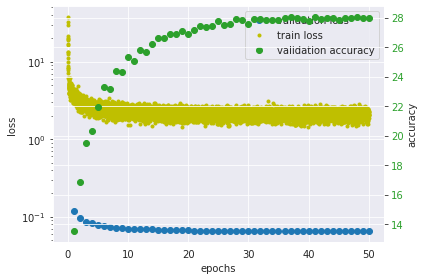

best acc: 28.04


In [25]:
run_train_test_loop(
    net4, 
    train_loader, 
    test_loader, 
    "cifar_10_width_8_freeze_layer4_reinit_conv1x1", 
    epochs=50, 
    device=device
)    

## Random feature experiments

In [26]:
c = 8
net5 = mCNN_k(c=c).to(device)

for p in net5[0].parameters():
    p.requires_grad = False
# for p in net5[2].parameters():
#     p.requires_grad = False
# for p in net5[5].parameters():
#     p.requires_grad = False
# for p in net5[8].parameters():
#     p.requires_grad = False


test(net5, device, test_loader, torch.nn.CrossEntropyLoss())
summary(net5)


Test set: Average loss: 0.0720, Accuracy: 1000/10000 (10%)



Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            (224)
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            1,152
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            4,608
├─ReLU: 1-7                              --
├─MaxPool2d: 1-8                         --
├─Conv2d: 1-9                            18,432
├─ReLU: 1-10                             --
├─MaxPool2d: 1-11                        --
├─MaxPool2d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           640
Total params: 25,056
Trainable params: 24,832
Non-trainable params: 224

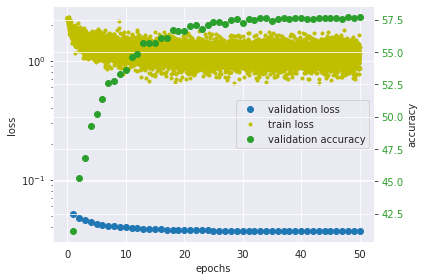

best acc: 57.69


In [27]:
run_train_test_loop(
    net5, 
    train_loader, 
    test_loader, 
    "cifar_10_width_8_freeze_layer1", 
    epochs=50, 
    device=device
)    

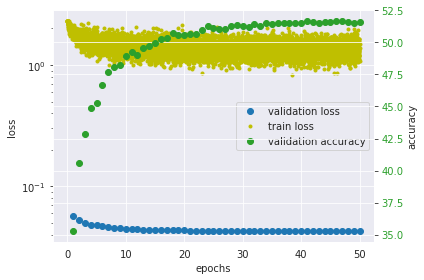

best acc: 51.68


In [28]:
c = 8
net5 = mCNN_k(c=c).to(device)

for p in net5[0].parameters():
    p.requires_grad = False
for p in net5[2].parameters():
    p.requires_grad = False
# for p in net5[5].parameters():
#     p.requires_grad = False
# for p in net5[8].parameters():
#     p.requires_grad = False


test(net5, device, test_loader, torch.nn.CrossEntropyLoss())
summary(net5)
run_train_test_loop(
    net5, 
    train_loader, 
    test_loader, 
    "cifar_10_width_8_freeze_layer2", 
    epochs=50, 
    device=device
)    

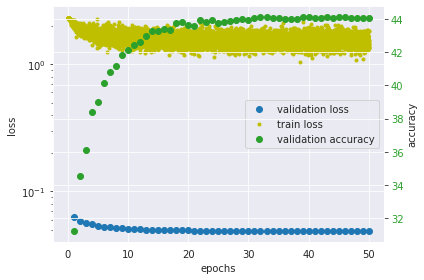

best acc: 44.11


In [29]:
c = 8
net5 = mCNN_k(c=c).to(device)

for p in net5[0].parameters():
    p.requires_grad = False
for p in net5[2].parameters():
    p.requires_grad = False
for p in net5[5].parameters():
    p.requires_grad = False
# for p in net5[8].parameters():
#     p.requires_grad = False


test(net5, device, test_loader, torch.nn.CrossEntropyLoss())
summary(net5)
run_train_test_loop(
    net5, 
    train_loader, 
    test_loader, 
    "cifar_10_width_8_freeze_layer3", 
    epochs=50, 
    device=device
)    

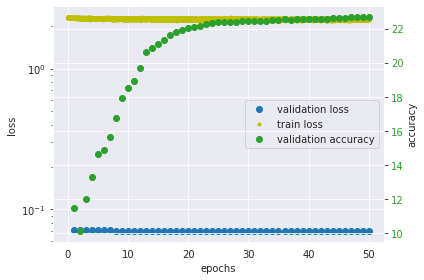

best acc: 22.67


In [30]:
c = 8
net5 = mCNN_k(c=c).to(device)

for p in net5[0].parameters():
    p.requires_grad = False
for p in net5[2].parameters():
    p.requires_grad = False
for p in net5[5].parameters():
    p.requires_grad = False
for p in net5[8].parameters():
    p.requires_grad = False


test(net5, device, test_loader, torch.nn.CrossEntropyLoss())
summary(net5)
run_train_test_loop(
    net5, 
    train_loader, 
    test_loader, 
    "cifar_10_width_8_freeze_layer4", 
    epochs=50, 
    device=device
)    

## Hybrid experiments

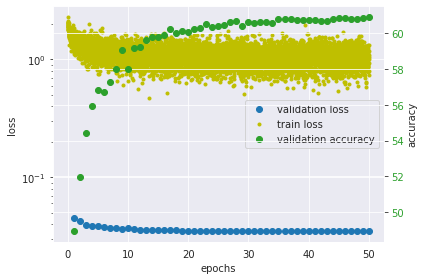

best acc: 60.9


In [7]:
c = 8
model = mCNN_k(c=c).to(device)
state_dict = torch.load("models/cifar_10_width_8.pt",) # map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

model[2] = LayerModifier(
    torch.nn.Conv2d(c, c * 2, kernel_size=3, stride=1, padding=1, bias=False), dims=c*2
).to(device)

for p in model[0].parameters():
    p.requires_grad = False
for p in model[2].parameters():
    p.requires_grad = False

new_state_dict = model.state_dict()
test(model, device, test_loader, torch.nn.CrossEntropyLoss())
summary(model)
run_train_test_loop(
    model, 
    train_loader, 
    test_loader, 
    "cifar_10_width_8_hybrid_layer2_reinit_conv1x1", 
    epochs=50, 
    device=device
)    

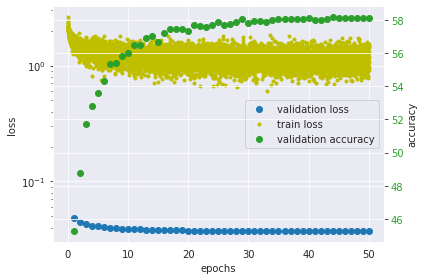

best acc: 58.17


In [8]:
c = 8
model = mCNN_k(c=c).to(device)
state_dict = torch.load("models/cifar_10_width_8.pt",) # map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

model[5] = LayerModifier(
    torch.nn.Conv2d(c * 2, c * 4, kernel_size=3, stride=1, padding=1, bias=False), dims=c*4
).to(device)


for p in model[0].parameters():
    p.requires_grad = False
for p in model[2].parameters():
    p.requires_grad = False
for p in model[5].parameters():
    p.requires_grad = False


new_state_dict = model.state_dict()
test(model, device, test_loader, torch.nn.CrossEntropyLoss())
summary(model)
run_train_test_loop(
    model, 
    train_loader, 
    test_loader, 
    "cifar_10_width_8_hybrid_layer3_reinit_conv1x1", 
    epochs=50, 
    device=device
)    

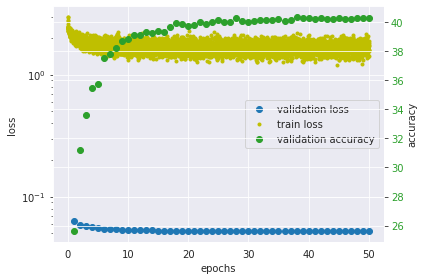

best acc: 40.35


In [9]:
c = 8
model = mCNN_k(c=c).to(device)
state_dict = torch.load("models/cifar_10_width_8.pt",) # map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

model[8] = LayerModifier(
    torch.nn.Conv2d(c * 4, c * 8, kernel_size=3, stride=1, padding=1, bias=False), dims=c*8
).to(device)

for p in model[0].parameters():
    p.requires_grad = False
for p in model[2].parameters():
    p.requires_grad = False
for p in model[5].parameters():
    p.requires_grad = False
for p in model[8].parameters():
    p.requires_grad = False


new_state_dict = model.state_dict()
test(model, device, test_loader, torch.nn.CrossEntropyLoss())
summary(model)
run_train_test_loop(
    model, 
    train_loader, 
    test_loader, 
    "cifar_10_width_8_hybrid_layer4_reinit_conv1x1", 
    epochs=50, 
    device=device
)    